## 代码实现

接下来，我们来学习照相机标定的代码实现。为了方便理解，我们不考虑照相机畸变的影响。整个流程包括从标定板图像中提取角点，计算单应性矩阵，求解内参矩阵，求解外参矩阵，最后通过重投影误差来评估标定的准确性。这里我们采用OpenCV样例中的标定图像作为样例，有条件的同学也可以自己打印或者购买标定板进行拍照获取标定板图像。
<!-- 在这里我们将介绍一下OpenCV标定算法的标定流程： -->
<!-- （1）：由于镜头畸变的影响比较小，首先假定照相机是理想无畸变的，根据角点的二维坐标与三维坐标的对应关系来计算初始的照相机内参；
（2）：求解照相机外参；
（3）：应用最小二乘求解实际的畸变系数；
（4）：根据求解的内外参对空间点进行重投影，应用全局$Levenberg-Marquardt$优化算法来最小化重投影和原投影点之间的误差。 -->

In [4]:
# 首先clone对应仓库
! git clone https://github.com/boyu-ai/Hands-on-CV.git

Cloning into 'Hands-on-CV'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


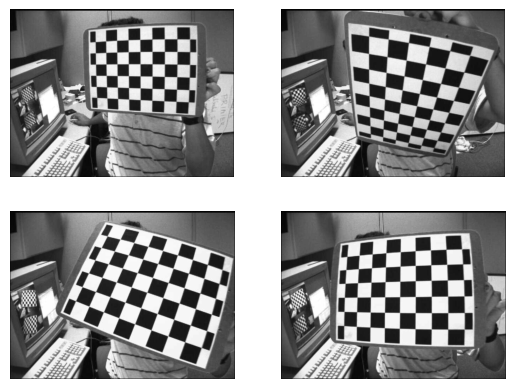

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 首先获取图像路径
image_dirs = sorted(glob.glob("./Hands-on-CV/第13章 照相机标定/left*.jpg"), 
                    key=lambda x: int(x.split("/")[-1].split(".")[0][4:]))

# 可视化4张棋盘格图像
plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    img = cv2.imread(image_dirs[i], 0)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

从上图可以看到在标定板上的角点，我们可以通过角点检测算法来获取这些角点的坐标。在OpenCV中提供了一个函数 `cv2.findChessboardCorners()` 来帮助我们检测棋盘格角点。

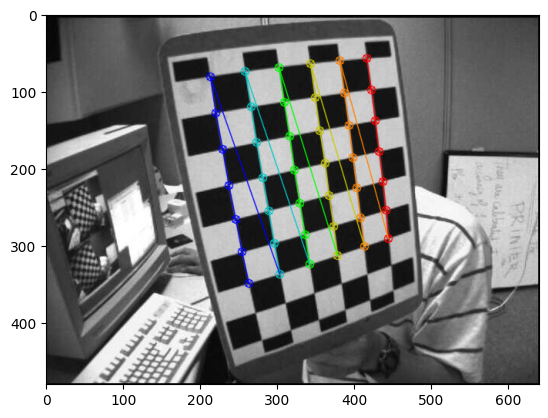

In [54]:
def detect_corner(image_dirs):
    """
    检测图像中的角点并返回，同时可视化角点检测效果。
    """
    # 根据标定板决定用来标定的角点的个数，这里以(7, 6)为例
    num_corner = (7, 6)
    # 创建一个列表来保存每张图像中角点的三维坐标
    objpoints = []
    # 创建一个列表来保存每张图像中角点的二维坐标
    imgpoints = []

    #定义三维坐标:[row, co1, z]
    objp = np.zeros((6*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:num_corner[0], \
                0:num_corner[1]].T.reshape(-1,2)

    # 遍历所有图像，找到角点
    for fname in image_dirs:
        img = cv2.imread(fname)
        # 转化成灰度图，方便角点检测
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        # 使用角点检测寻找角点坐标，如果找到ret返回True
        # 左上角为坐标原点
        ret, corners = cv2.findChessboardCorners(gray, num_corner, None)
        # 根据ret的状态来记录角点
        if ret == True:
            objpoints.append(objp[:, :2])
            imgpoints.append(corners.reshape(-1, 2))

    # 使用OpenCV自带的绘图可视化角点检测效果，从红色开始绘制，紫色结束
    cv2.drawChessboardCorners(img, (7,6), corners, ret)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return objpoints, imgpoints, gray

# 调用detect_corner函数检测每张图像的角点
objpoints, imgpoints, gray = detect_corner(image_dirs)

到这里我们就得到了图像上角点的图像坐标以及其对应的世界坐标系中的坐标，接下来我们就可以利用这些坐标之间的对应关系求解单应性矩阵 $\boldsymbol{H}$。

In [3]:
def normalizing_input_data(coor_data):
    # 计算坐标数据的平均值
    x_avg = np.mean(coor_data[:, 0])
    y_avg = np.mean(coor_data[:, 1])
    # 计算坐标数据的标准差，并用它来计算尺度因子，使得归一化后的坐标的标准差为sqrt(2)
    sx = np.sqrt(2) / np.std(coor_data[:, 0])
    sy = np.sqrt(2) / np.std(coor_data[:, 1])
    # 构造归一化矩阵，用于将坐标归一化，使均值为0，标准差为sqrt(2)
    norm_matrix = np.array([[sx, 0, -sx * x_avg],
                             [0, sy, -sy * y_avg],
                             [0, 0, 1]])
    return norm_matrix


def compute_homography(pic_coor, real_coor):
    """
    计算单应性矩阵H。

    参数：
    - pic_coor: 图像坐标系坐标。
    - real_coor: 世界坐标系坐标。

    返回：
    - H: 单应性矩阵。
    """
    pic_norm_mat = normalizing_input_data(pic_coor)
    real_norm_mat = normalizing_input_data(real_coor)
    
    A = []  # 构建用于求解H的线性方程组
    for i in range(len(pic_coor)):
        # 将当前的图像坐标系坐标和世界坐标系坐标转换为齐次坐标
        single_pic_coor = np.array([pic_coor[i][0], pic_coor[i][1], 1])
        single_real_coor = np.array([real_coor[i][0], real_coor[i][1], 1])

        # 对坐标进行归一化处理
        pic_norm = np.dot(pic_norm_mat, single_pic_coor)
        real_norm = np.dot(real_norm_mat, single_real_coor)

        # 根据归一化后的坐标构造矩阵A的行
        # 这部分实现了将单应性矩阵H的约束条件转换为线性方程的过程
        A.append(np.array([-real_norm.item(0), -real_norm.item(1), -1, 0, 0, 0,
            pic_norm.item(0) * real_norm.item(0), pic_norm.item(0) * real_norm.item(1),
            pic_norm.item(0)]))
        A.append(np.array([0, 0, 0, -real_norm.item(0), -real_norm.item(1), -1,
            pic_norm.item(1) * real_norm.item(0), pic_norm.item(1) * real_norm.item(1),
            pic_norm.item(1)]))

    # 使用奇异值分解(SVD)求解Mh=0中的h，即单应性矩阵H的向量化形式
    U, S, VT = np.linalg.svd((np.array(A, dtype='float')).reshape((-1, 9)))
    H = VT[-1].reshape((3, 3))  # 最小奇异值对应的奇异向量重塑为3x3矩阵
    
    # 对H进行反归一化处理
    H = np.dot(np.dot(np.linalg.inv(pic_norm_mat), H), real_norm_mat)
    H = H / H[-1, -1]  # 归一化，确保H的最后一个元素为1

    return H

H_list = []
for i in range(len(objpoints)):
    H = compute_homography(imgpoints[i], objpoints[i])
    H_list.append(H)
    if i < 3:
        print("第{}张图像的单应性矩阵为：\n{}".format(i+1, H))

第1张图像的单应性矩阵为：
[[-2.90500492e+01 -2.05911540e+00  4.76529133e+02]
 [ 2.28048296e+00 -3.63192023e+01  2.64694023e+02]
 [ 1.49422654e-02 -5.06829993e-03  1.00000000e+00]]
第2张图像的单应性矩阵为：
[[-1.28830042e+01  3.91039199e+01  2.53736256e+02]
 [-4.27973766e+01  7.39439498e+00  3.09778969e+02]
 [-4.92899678e-02 -3.79194108e-03  1.00000000e+00]]
第3张图像的单应性矩阵为：
[[-4.25026982e+01  2.84366906e+01  5.00044815e+02]
 [-1.26971800e+01 -4.04613414e+01  3.75934812e+02]
 [ 1.57645215e-02  2.74643346e-02  1.00000000e+00]]


在得到了每张标定板图像对应的 $\boldsymbol{H}$ 之后，我们首先需要从每个单应性矩阵 $\boldsymbol H$ 中提取出用于解矩阵 $\boldsymbol B$ 的约束方程。然后再通过SVD分解求解出 $\boldsymbol B$，最后通过楚列斯基分解求解出照相机的内参矩阵 $\boldsymbol K$。

In [12]:
def compute_B_matrix(H_list):
    """
    从单应性矩阵H列表中计算B矩阵。

    参数：
    - H_list: 单应性矩阵H的列表。

    返回：
    - B: B矩阵。
    """
    V = []

    for H in H_list:
        # 分解H矩阵以获得其列向量
        h1, h2, _ = H[:,0], H[:,1], H[:,2]
        # 根据旋转矩阵的正交性质构造V矩阵的行
        # v_ij 是构造方程 hi^T * B * hj = 0 的向量形式
        # 由于 h = K * r，我们可以用 h 来代替 r
        
        # 第一个方程来自于 r1^T * r2 = 0 -> (h1^T * B * h2 = 0)
        v12 = np.array([h1[0]*h2[0], h1[0]*h2[1] + h1[1]*h2[0], h1[1]*h2[1], 
            h1[2]*h2[0] + h1[0]*h2[2], h1[2]*h2[1] + h1[1]*h2[2], h1[2]*h2[2]])
        
        # 第二个方程来自于 r1^T * r1 = r2^T * r2 -> 
        # ((h1^T * B * h1) - (h2^T * B * h2) = 0)
        v11_v22 = np.array([h1[0]**2 - h2[0]**2, 2*(h1[0]*h1[1] - h2[0]*h2[1]), 
                            h1[1]**2 - h2[1]**2, 2*(h1[2]*h1[0] - h2[2]*h2[0]), 
                            2*(h1[2]*h1[1] - h2[2]*h2[1]), h1[2]**2 - h2[2]**2])

        # 将这两个方程添加到V矩阵中
        V.append(v12)
        V.append(v11_v22)

    V = np.array(V)

    # 使用SVD求解b，其中b是B矩阵的六个未知数的向量形式
    U, S, Vt = np.linalg.svd(V)
    b = Vt[-1]  # 与最小奇异值对应的奇异向量

    # 根据b重构B矩阵
    B = np.array([[b[0], b[1], b[3]],
                  [b[1], b[2], b[4]],
                  [b[3], b[4], b[5]]])

    return B

B = compute_B_matrix(H_list)
print("B矩阵为：\n{}".format(B))

B矩阵为：
[[ 2.16451749e-06  7.58169969e-09 -7.67824576e-04]
 [ 7.58169969e-09  2.15556058e-06 -4.90907403e-04]
 [-7.67824576e-04 -4.90907403e-04  9.99999585e-01]]


接下来我们使用楚列斯基分解求解出照相机的内参矩阵 $\boldsymbol K$。

In [17]:
def cholesky_solve(B):
  """
  利用楚列斯基分解求解 K 矩阵。
  """
  # 检查 B 是否为对称矩阵
  if not np.allclose(B, B.T):
    raise ValueError("B is not a symmetric matrix")

  # 进行楚列斯基分解
  L = np.linalg.cholesky(B)

  # L是下三角矩阵，而我们的K是上三角矩阵
  K = np.linalg.inv(L.T)

  # K矩阵的最后一个元素为1
  K = K / K[-1, -1]
  return K

# 直接求解
K = cholesky_solve(B)
print("K矩阵为：\n{}".format(K))

K矩阵为：
[[533.92350191  -1.87407784 353.93909352]
 [  0.         535.03494272 226.49511563]
 [  0.           0.           1.        ]]


接下来我们再从单应性矩阵计算照相机的外参矩阵 $[\boldsymbol{R} | \boldsymbol{t}]$。

In [24]:
def get_extrinsics_param(H, intrinsics_param):
    """
    从单应性矩阵H和内参矩阵K中计算外参矩阵R和平移向量t，并确保R的行列式为1。

    参数：
    - H: 单应性矩阵H列表。
    - intrinsics_param: 内参矩阵K。

    返回：
    - extrinsics_param: 包含外参矩阵R和平移向量t的列表。
    """
    extrinsics_param = []

    inv_intrinsics_param = np.linalg.inv(intrinsics_param)
    for i in range(len(H)):
        h0 = (H[i].reshape(3, 3))[:, 0]
        h1 = (H[i].reshape(3, 3))[:, 1]
        h2 = (H[i].reshape(3, 3))[:, 2]

        scale_factor = 1 / np.linalg.norm(np.dot(inv_intrinsics_param, h0))

        r0 = scale_factor * np.dot(inv_intrinsics_param, h0)
        r1 = scale_factor * np.dot(inv_intrinsics_param, h1)
        t = scale_factor * np.dot(inv_intrinsics_param, h2)
        r2 = np.cross(r0, r1)

        # 构成近似旋转矩阵
        R_approx = np.array([r0, r1, r2]).transpose()
        
        # 使用SVD来修正R，确保其符合旋转矩阵的性质
        U, _, Vt = np.linalg.svd(R_approx)
        R_corrected = np.dot(U, Vt)
        
        # 确保R的行列式为1
        if np.linalg.det(R_corrected) < 0:
            U[:, -1] *= -1  # 调整U的最后一列
            R_corrected = np.dot(U, Vt)  # 重新计算R

        extrinsics = np.column_stack((R_corrected, t))
        extrinsics_param.append(extrinsics)

    return extrinsics_param


extrinsics_param = get_extrinsics_param(H_list, K)
for i in range(len(extrinsics_param)):
    print("第{}张图像的外参矩阵为：\n{}".format(i+1, extrinsics_param[i]))
    if i == 2:
        break

第1张图像的外参矩阵为：
[[-9.73670749e-01  9.02344992e-04  2.27957142e-01  3.47913167e+00]
 [-1.90344917e-02 -9.96821819e-01 -7.73559911e-02  1.08066170e+00]
 [ 2.27162851e-01 -7.96583141e-02  9.70593423e-01  1.51363433e+01]]
第2张图像的外参矩阵为：
[[ 0.11529592  0.97966689  0.16419391 -2.41686208]
 [-0.76215049  0.19325491 -0.61788281  2.01046147]
 [-0.63705061 -0.0539011   0.7689351  12.91567438]]
第3张图像的外参矩阵为：
[[-0.9339432   0.35280444  0.05726373  2.84741705]
 [-0.31749332 -0.89247809  0.32043853  2.89596682]
 [ 0.16415876  0.28109053  0.94553689 10.36835246]]


接下来我们可以将空间中点根据我们计算得到的内参和外参投影到图像平面上，然后计算重投影误差来判断我们标定的准确程度。

In [37]:
def reproject_error(K, extrinsic, pixel_coor, real_coor):
    """
    计算重投影误差。

    参数：
    - K: 内参矩阵。
    - extrinsic: 外参矩阵。
    - pixel_coor: 图像坐标系坐标。
    - real_coor: 世界坐标系坐标。

    返回：
    - error: 重投影误差。
    """
    # 计算投影矩阵
    P = np.dot(K, extrinsic)
    
    # 将世界坐标系坐标转换为齐次坐标
    real_coor = np.column_stack((real_coor, np.zeros(len(real_coor)), 
                                 np.ones(len(real_coor))))
    
    # 计算重投影坐标
    reprojected_coor = np.dot(P, real_coor.T).T
    reprojected_coor = reprojected_coor[:, :2] / reprojected_coor[:, 2:3]

    # 计算重投影误差
    error = np.linalg.norm(reprojected_coor - pixel_coor, axis=1)
    
    return error.mean()

# 将内外参矩阵都转化为齐次坐标
K_homo = np.column_stack((K, np.zeros(3)))
K_homo = np.row_stack((K_homo, [0, 0, 0, 1]))

# 计算所有图像重投影误差的均值
mean_error = 0
for j in range(len(imgpoints)):
    extrinsic_homo = np.row_stack((extrinsics_param[j], [0, 0, 0, 1]))

    # 计算每一张图像的重投影误差
    error = reproject_error(K_homo, extrinsic_homo, imgpoints[j], objpoints[j])
    mean_error += error

# 得到平均重投影误差
mean_error /= len(imgpoints) 
print("平均重投影误差为: {}".format(mean_error))

平均重投影误差为: 2.2527822694246837


到这里，我们就完成了基础的照相机标定流程。从重投影误差来看，我们计算出来的照相机参数还是比较精确的，平均误差为 2.25 个像素。在实际应用过程中，我们往往直接使用 OpenCV 的标定函数来实现照相机标定：

In [63]:
# 转换成OpenCV需要的格式
objpoints_cv = [np.hstack((i, np.zeros((i.shape[0], 1)))).astype(
                np.float32) for i in objpoints]
imgpoints_cv = [i[:,None,:] for i in imgpoints]

# 使用OpenCV的标定函数来标定照相机
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints_cv, 
                                imgpoints_cv, gray.shape[::-1], None, None)

print("照相机内参:")
# 照相机内参，输出格式为 [[fx,0,cx],[0,fy,cy],[0,0,1]]
print(mtx,"\n")

print("畸变参数:")
# k1,k2,p1,p2,k3
print(dist)

照相机内参:
[[530.16217137   0.         341.48703364]
 [  0.         530.21111757 230.10277488]
 [  0.           0.           1.        ]] 

畸变参数:
[[-3.60236613e-01  8.54966618e-01  5.79031024e-04 -4.97455055e-04
  -2.16444973e+00]]


In [62]:
# 初始化误差
mean_error = 0
for i in range(len(objpoints_cv)):
    # 使用内外参和畸变参数对点进行重投影
    imgpoints2, _ = cv2.projectPoints(objpoints_cv[i], 
                             rvecs[i], tvecs[i], mtx, dist)
    # 计算重投影点与原始点的误差，使用欧几里得距离进行衡量
    error = cv2.norm(imgpoints_cv[i], imgpoints2, 
                             cv2.NORM_L2) / len(imgpoints2)
    # 累加误差
    mean_error += error
    
# 得到平均每个点偏移像素的二范数
mean_error /= len(objpoints_cv) 
print("OpenCV得到的平均重投影误差为: {}".format(mean_error))

OpenCV得到的平均重投影误差为: 0.062162126761103303


可以发现我们的简易算法和OpenCV得到的标定结果大体上是一致的，只是精度上有一些差异，主要原因是畸变参数的影响。

## 16.4 小结

本章主要介绍了照相机成像的基本原理，以及照相机模型中重要的参数：内外参数和畸变参数。我们还学习了如何使用标定板对照相机进行标定，并通过代码实现了照相机的标定。经过标定的照相机，犹如一座连接三维世界与二维图像平面的桥梁。它让我们能够通过图像来反向推算三维空间的信息，为后续的计算机视觉应用提供重要的基础。下一节，我们将学习光流与运动场，探究空间运动与图像像素变化之间的关系。

## 16.5 习题

#### 习题16.1：我们在标定过程中默认标定板上每个方格的边长为 1 m，而不是其真实的物理长度，这样会对标定结果产生影响吗？为什么？

#### 习题16.2：试思考径向畸变和切相畸变哪一个更常见？为什么？

#### 习题16.3：棋盘格标定板是照相机标定中常用的标定板，那么在实际应用中，是否可以使用其他形式的标定板进行标定？请举例说明。

#### 习题16.4：角点识别的精度会影响到标定的结果，试思考如何减少其误差带来的影响。